# Multi object maps in images

In the previous lesson we began by looking at what sort of data a JPEG image stores.  After an initial exploration of this, we considered an example case of what opportunties this data affords us.  We saw that we could use the information contained within the colors to do things like select those specific pixels which corresponded to water.  Quite importantly, we also began to get a sense of how we could move images relative to one another such that the pixels were as close to depicting the same peices of the earth's surface as possible.

In this lesson we will build on these insights in a fairly specific fashion.  Previously, we were only selecting those pixels which corresponded to the ocean.  But what if we wanted to select pixels that corresponded to *other* aspects of the world?  Say, for example, I had a political map which somehow uniquely indicated a country of interest, and wished to perform an analysis on the sattalite image pixels that corresponded to this country.  How would I go about doing this?

In this lesson we'll be using maps of the united states to explore this capability.  We are shifting our focus from the entire world to the United states, in order to avoid as much of the skewing problems we observed in the previous lesson as possible (though we'll see that we can't entirely get away from them here either).

Lets begin by setting the path names, and establishing a standard image size for what we'll be looking at.

In [1]:
#lets begin by setting up paths and files

#this code ensures that we can navigate the WiMSE repo across multiple systems
import subprocess
import os
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

#get top directory path of the current git repository, under the presumption that 
#the notebook was launched from within the repo directory
gitRepoPath=subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('ascii').strip()

#move to the top of the directory
os.chdir(gitRepoPath)

#file name of geographical map of US
usGeoName='USA-satellite.jpg'

#file name of political map of US
usPolitical='Map_of_USA_with_states_modified.png'

#an image resolution that's a good comprimize between the two images we will be looking at
standardResize=[600,1000]

Lets plot the [satallite photo of the United States](https://en.m.wikipedia.org/wiki/File:USA-satellite.jpg).  As before, we will select a water pixel (500,50; off the coast of the Baja peninsula) that will be used to create a surface water map, as in the previous chapter.  However, we'll also be building upon this by using this mask to help us narrow our consideration of a map.  For now though, lets inspect the map.

Original map size
(675, 1082, 3)

Resized map dimensions
(1000, 600)

RGB value for water pixel ([500,50])
[14 12 59]


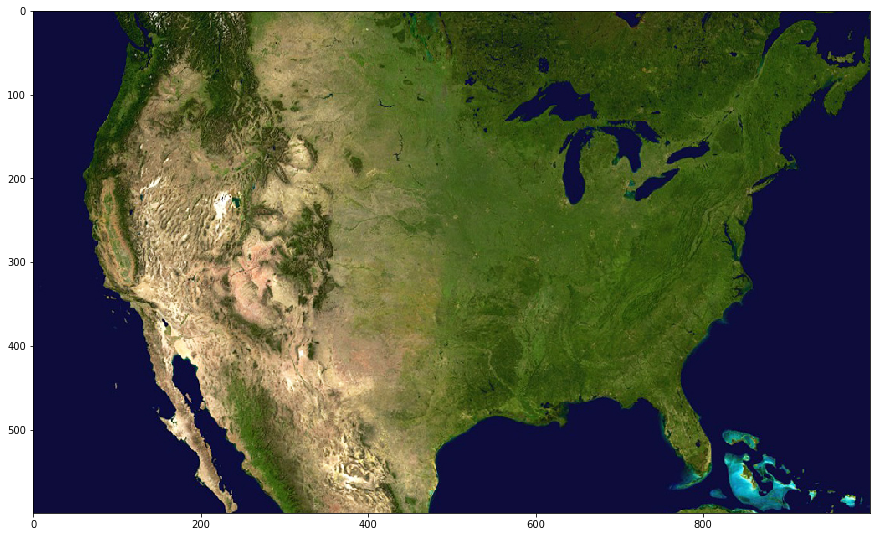

In [2]:
#loading image processing and manipulation package Pillow
# https://pillow.readthedocs.io/en/stable/
import PIL
from PIL import Image
import os
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np

#extract the image data and print the size of the origonal file
usGeoMapPath=os.path.join(gitRepoPath,'images',usGeoName) 
usGeoMap= Image.open(usGeoMapPath)
geoMapArray=np.asarray(usGeoMap)
usGeoMapShape=geoMapArray.shape
print('Original map size')
print(usGeoMapShape)
print('')

#resize to a standard resolution
geoMapImgResize=usGeoMap.resize([standardResize[1],standardResize[0]], resample=0)
print('Resized map dimensions')
print(geoMapImgResize.size)
print('')

#display the image
%matplotlib inline
geoResizeData=np.asarray(geoMapImgResize)
imshow(geoResizeData)
fig = plt.gcf()
fig.set_size_inches(15, 30)

#select a water pixel and post some information about it
WaterColor=geoResizeData[500,50]
print('RGB value for water pixel ([500,50])')
print(WaterColor)

Above, we see a standard satallite image of the continental united states.  Lucky for us it seems that we'll be quite fortunate in trying to make a "water mask" as the color of water appears to be fairly uniform (except in the case of islands near the Bahamas).  We will use this water mask to align this image with another map, as the coasts will provide us with some helpful discrete borders to align with.

As we did in the prevous lesson, lets go ahead and compute the color distances from this water color.  We'll then plot these distances as we did previously, so we can get a sense of the range of color distances in the map.

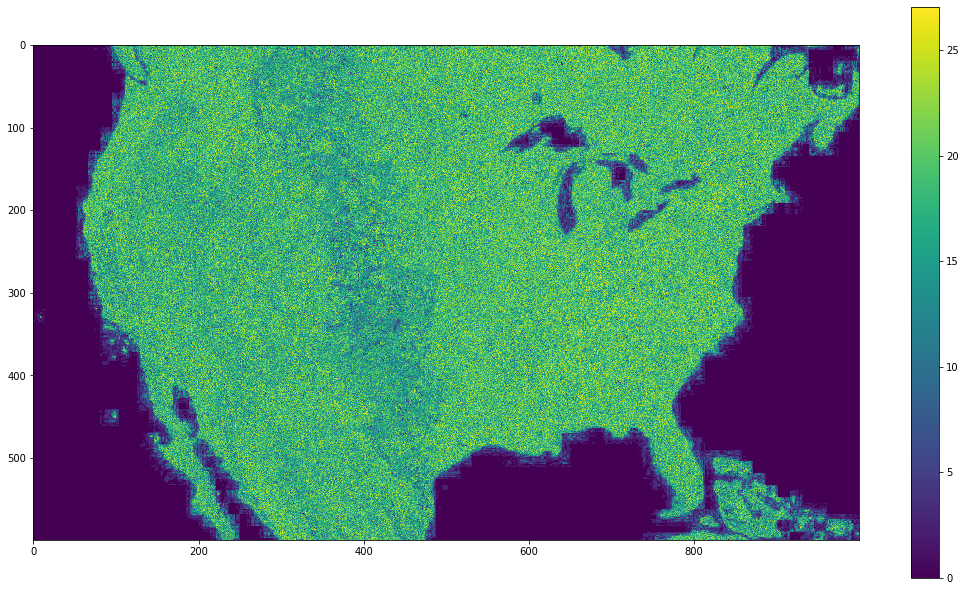

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#quick and dirty general use hypoteuse algorithm, can be used for 2d or 3D
def multiDHypot(coords1,coords2):
    dimDisplace=np.subtract(coords1,coords2)
    elementNum=dimDisplace.size
    elementSquare=np.square(dimDisplace)
    elementSquareSum=np.sum(elementSquare)
    if elementNum==1:
        hypotLeng=dimDisplace
    elif elementNum==2:
        hypotLeng=np.sqrt(elementSquareSum)
    elif elementNum==3:
        hypotLeng=np.sqrt(elementSquareSum)
    return hypotLeng

#establish blank storage strucure
colorGeoDistMeasures=np.zeros([standardResize[0],standardResize[1]])

#iterate across pixels
for iRows in range(standardResize[0]):
    for iColumns in range(standardResize[1]):
        #for all colors
        curPixelVal=geoResizeData[iRows,iColumns]
        
        #or maybe just a single color
        #curPixelVal=zeroBlueMask[iRows,iColumns,0]
        
        #could be done with raw input
        colorGeoDistMeasures[iRows,iColumns]=multiDHypot(curPixelVal,WaterColor)
        
#transorm the output into a usable format
flattenedDistances=np.ndarray.flatten(colorGeoDistMeasures)

#plot the distance output as an image
heatPlot=plt.imshow(colorGeoDistMeasures)
fig2=plt.gcf()
fig2.colorbar(heatPlot)
fig2.set_size_inches(18.5, 10.5)


It seems that the ocean is fairly uniform, but the continental united states is a bit less so, such that many areas appear to be getting close to distances contained in the ocean.  Also there appears to be a good deal of jpeg artifacting, as discussed in previous chapters (note the "blocky" color fuzz that is visible in coastal areas).  Will this issues cause a problem when we try and make a mask?  

Lets try and come up with a good threshold color distance we can use to make a mask for this data.  Keep in mind that this is only a rough approximation, and that we aren't going to get a perfect mask with this method.

#### What's the best cutoff value for this map?

**NOTE:  as with the previous lesson, the mask you generate here will be used in later sections.  Once you create the map do not hit Run again.  Instead, click on the next cell and continue pressing Run from that point.**

In [4]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import IntSlider
from ipywidgets import FloatSlider

#update of plots using the 
def updatePlots(colorGeoDistMeasures,geoCutVal):
    
    #transform data into useable format
    flattenedDistances=np.ndarray.flatten(colorGeoDistMeasures)
    
    #do the plotting
    plt.subplot(2, 1, 1)
    plt.hist(flattenedDistances, bins=100)
    plt.xlabel('Distance from ocean color')
    plt.ylabel('Number of pixels')
    plt.title('Distributon of RGB color distance from Atlantic pixel color')
    xposition = [geoCutVal]
    #create treshold indicator
    for xc in xposition:
        plt.axvline(x=xc, color='r', linestyle='--', linewidth=3)
    distHist = plt.gcf()
    distHist.set_size_inches(20, 10)
    
    
    geoOceanMask=colorGeoDistMeasures<geoCutVal
    plt.subplot(2, 1, 2)
    imshow(geoOceanMask)
    distMap = plt.gcf()
    distMap.set_size_inches(10, 10)

        
#def update_bound(minimum, maximum):
#    global upperBound
#    global lowerBound
#    lowerBound = minimum
#    upperBound = maximum
#    draw_adaptiveMatrix

#wrapper for updating the cutVal
def updateCut(geoCutVal):
    updatePlots(colorGeoDistMeasures,geoCutVal)

#set threshold variable
geoCutVal=FloatSlider(min=np.min(flattenedDistances), max=np.max(flattenedDistances), step=1,continuous_update=False)

#establish interactivity
interact(updateCut, geoCutVal=geoCutVal) 


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='geoCutVal', max=27.03701166…

<function __main__.updateCut(geoCutVal)>

It seems that a value around 5 should be just fine for this map.  In fact, there's actually a fairly large range of values that could work for this mask.  The areas where your choice will have the most impact will be on the coasts and the Great Lakes.

Now that we have our mask for our geographic data, look at the other map we will be attempting to align to this.  Below, we'll load the data, convert it to a RGB image, resize it so that it is the same size as the geographic map, and then extract the color value for a reprsentative water pixel (taken from roughly the same location in this map as it was from the previous map). 

Initial political map dimensions
(591, 958, 4)

Dimensions after conversion to RGB
(591, 958, 3)

Dimensions after resize to geographic map dimensions
(600, 1000, 3)

RGB value for water pixel [500,50]
[158 199 243]



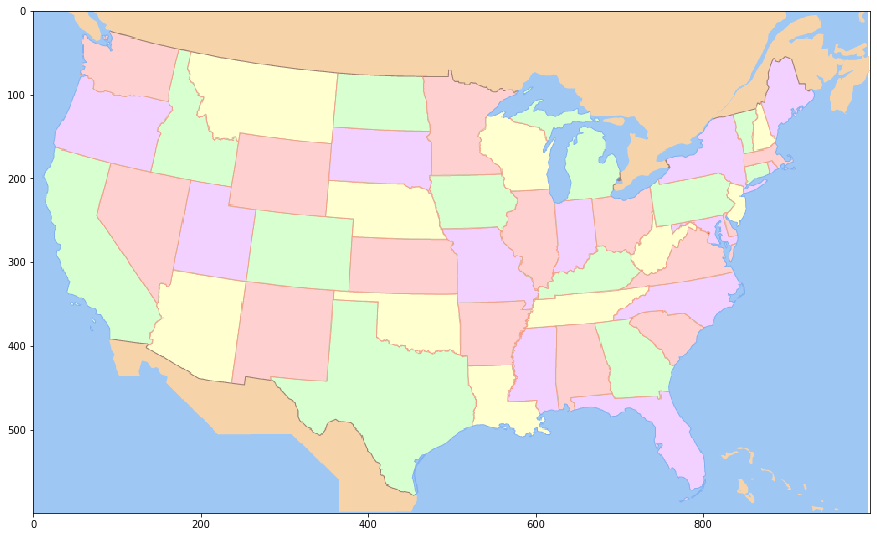

In [5]:
#establish path to political map
politicalMapPath=os.path.join(gitRepoPath,'images',usPolitical)   

#open the image
politicalMap= Image.open(politicalMapPath)
#convert it to a data array
politicalMapData=np.asarray(politicalMap)
#obtain its shape
politicalMapShape=politicalMapData.shape
print('Initial political map dimensions')
print(politicalMapShape)
print('')
#note that it appears to be a CMYK image

#lets convert it to RGB just for ease of use
rgb_Pol = politicalMap.convert('RGB')
rgb_PolData=np.asarray(rgb_Pol)
print('Dimensions after conversion to RGB')
print(rgb_PolData.shape)
print('')

#resize the data so it meets the standard we established earlier
politicalResized=rgb_Pol.resize([standardResize[1],standardResize[0]], resample=0)
politicalResizedData=np.asarray(politicalResized)
print('Dimensions after resize to geographic map dimensions')
print(politicalResizedData.shape)
print('')

#plotting
%matplotlib inline
imshow(politicalResizedData)
fig = plt.gcf()
fig.set_size_inches(15, 30)

#lets extract the water color for this image as well.
politicalWater=politicalResizedData[500,50]
print('RGB value for water pixel [500,50]')
print(politicalWater)
print('')

Above, we see a political map of the United Staes, with individual states colored in a semi-random (no adjacent divisions are colored the same) fashion.  Interestingly, the color scheme for this map appears to be rather limited, in that there are actually only a very limited number (6, in total) of unique colors being used.  This is something we can use to our advantage.  As we will see later, we can treat each of these colors just as we did with the ocean color in the previous lesson and select those specific pixels (i.e. states) that correspond to the color in question.

For now though, lets plot the color distance map for this map.

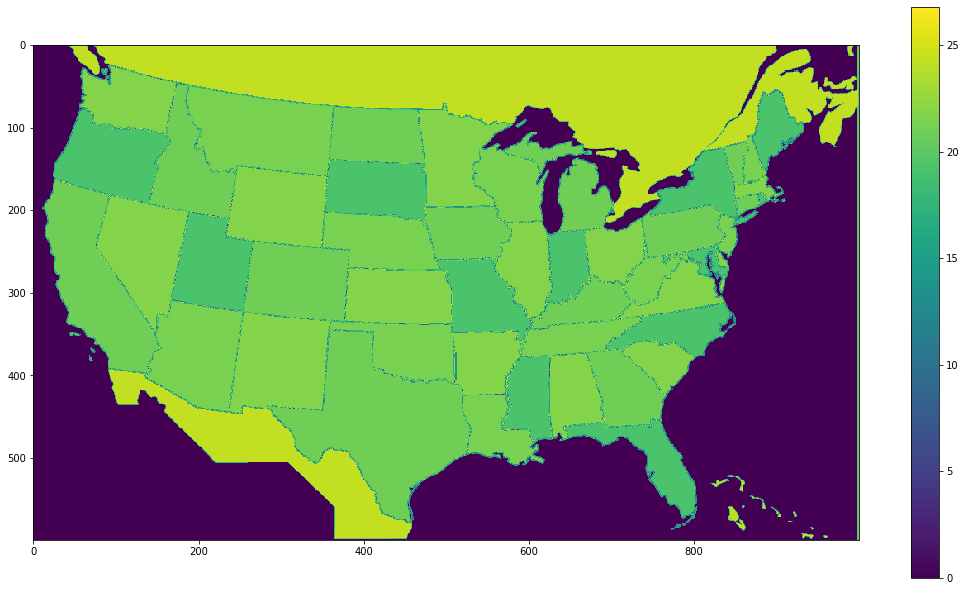

In [6]:
import numpy as np
import matplotlib.pyplot as plt

#quick and dirty general use hypoteuse algorithm, can be used for 2d or 3D
def multiDHypot(coords1,coords2):
    dimDisplace=np.subtract(coords1,coords2)
    elementNum=dimDisplace.size
    elementSquare=np.square(dimDisplace)
    elementSquareSum=np.sum(elementSquare)
    if elementNum==1:
        hypotLeng=dimDisplace
    elif elementNum>1:
        hypotLeng=np.sqrt(elementSquareSum)
    return hypotLeng

#establish storage structure
colorPoliticalDistMeasures=np.zeros([standardResize[0],standardResize[1]])

#iterate across pixels
for iRows in range(standardResize[0]):
    for iColumns in range(standardResize[1]):
        #for all colors
        curPixelVal=politicalResizedData[iRows,iColumns]
        
        #or maybe just a single color
        #curPixelVal=zeroBlueMask[iRows,iColumns,0]
        
        #could be done with raw input
        colorPoliticalDistMeasures[iRows,iColumns]=multiDHypot(curPixelVal,politicalWater)

#convert output into a usable format
flattenedPoliticalDistances=np.ndarray.flatten(colorPoliticalDistMeasures)

#plot the result
heatPlot=plt.imshow(colorPoliticalDistMeasures)
fig3=plt.gcf()
fig3.colorbar(heatPlot)
fig3.set_size_inches(18.5, 10.5)

As before, lets try and establish a threshold value to isolate water that works well for this political map.

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import IntSlider
from ipywidgets import FloatSlider

#update of plot function
def updatePlots(colorPoliticalDistMeasures,polCutVal):

    flattenedDistances=np.ndarray.flatten(colorPoliticalDistMeasures)
    
    #plotting code
    plt.subplot(2, 1, 1)
    plt.hist(flattenedDistances, bins=100)
    plt.xlabel('Distance from ocean color')
    plt.ylabel('Number of pixels')
    plt.title('Distributon of RGB color distance from Atlantic pixel color')
    xposition = [polCutVal]
    for xc in xposition:
        plt.axvline(x=xc, color='r', linestyle='--', linewidth=3)
    distHist = plt.gcf()
    distHist.set_size_inches(20, 10)
    
    geoOceanMask=colorPoliticalDistMeasures<polCutVal
    plt.subplot(2, 1, 2)
    imshow(geoOceanMask)
    distMap = plt.gcf()
    distMap.set_size_inches(10, 10)

#wrapper function
def updateCut(polCutVal):
    updatePlots(colorPoliticalDistMeasures,polCutVal)

#set theshold variable
polCutVal=FloatSlider(min=np.min(flattenedDistances), max=np.max(flattenedDistances), step=1,continuous_update=False)

#establish interactivity
interact(updateCut, polCutVal=polCutVal) 

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='polCutVal', max=27.03701166…

<function __main__.updateCut(polCutVal)>

Basically anything less than 5 should work, given that there are very few colors in this map, there's a decent amount of wiggle room available.

Now that we have both masks, lets try and shift the political map on to the satellite map.

In [8]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import IntSlider

#apply threshold to geographic map and obtain mask
geoThreshMap=colorGeoDistMeasures>geoCutVal.value
#apply threshold to political map and obtain mask
polThreshMap=colorPoliticalDistMeasures>polCutVal.value

#plot the two maps
def plot_mapDiscrepancy(map1,map2): 
    discrepancyMapping=np.logical_xor(map1,map2)
    %matplotlib inline
    imshow(discrepancyMapping)
    fig = plt.gcf()
    fig.set_size_inches(15, 30)
    
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = 'Agree', 'Disagree'
    sizes = [np.sum(discrepancyMapping==0),np.sum(discrepancyMapping==1)]

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes,  labels=labels, autopct='%1.3f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

#function for moving the political map around
def update(xOffset, yOffset):
    polThreshMapMoved = np.roll(polThreshMap,yOffset,0)
    polThreshMapMoved = np.roll(polThreshMapMoved,xOffset,1)
    plot_mapDiscrepancy(geoThreshMap,polThreshMapMoved)
    
#establish the two offset variables and their associated widget
xOffset=IntSlider(min=-50, max=50, step=1,continuous_update=False)    
yOffset=IntSlider(min=-50, max=50, step=1,continuous_update=False)

#establish interactivity
interact(update, xOffset=xOffset,yOffset= yOffset)

interactive(children=(IntSlider(value=0, continuous_update=False, description='xOffset', max=50, min=-50), Int…

<function __main__.update(xOffset, yOffset)>

With a bit of experimentation, it should be possible to get the disagreement percentage down to around 10.5% , with an x offset of between 19 and 24 and a y offset of -8.

**Why did we bother aligning these two images?** 

Lets think back to the original political map, and in particular, the histogram of color distnaces.  Notice anything about the shape?  It's rather jagged, with only a few columns represented to any signifigant degree.  This is because there is a very limited number of colors occuring in the map, and thus a very limited number of distances from the color of water in the map.  Lets consider some of those values below.

Pink RGB value
[242 208 255]
Orange RGB value
[247 211 170]
Red RGB value
[255 208 208]
Green RGB value
[215 255 208]
Yellow RGB value
[255 255 208]


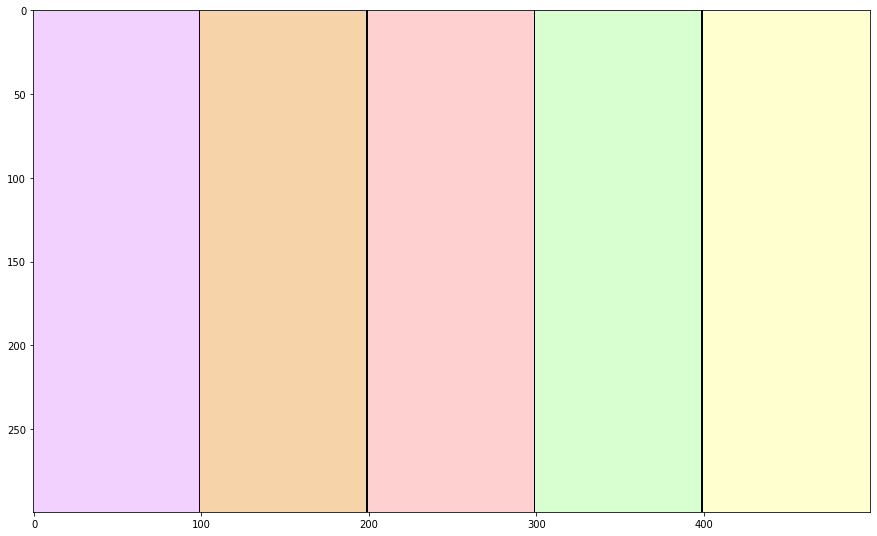

In [9]:
#extract representative pixels and color values for each unique color (of interest)
pinkPixel=politicalResizedData[150,100]
orangePixel=politicalResizedData[20,400]
redPixel=politicalResizedData[50,100]
greenPixel=politicalResizedData[450,400]
yellowPixel=politicalResizedData[400,200]

#print out the values for each of these
print('Pink RGB value')
print(pinkPixel)
print('Orange RGB value')
print(orangePixel)
print('Red RGB value')
print(redPixel)
print('Green RGB value')
print(greenPixel)
print('Yellow RGB value')
print(yellowPixel)

#establish stucture for storing color information
colorArray=np.zeros([300,500,3], dtype=int)

#fill in the data for each unique color of interest
colorArray[0:300,0:99,:]=pinkPixel.astype(int)
colorArray[0:300,100:199,:]=orangePixel.astype(int)
colorArray[0:300,200:299,:]=redPixel.astype(int)
colorArray[0:300,300:399,:]=greenPixel.astype(int)
colorArray[0:300,400:500,:]=yellowPixel.astype(int)

#plot this data as an image
%matplotlib inline
imshow(colorArray)
fig = plt.gcf()
fig.set_size_inches(15, 30)

Compare the color swatches above to the political map found earlier.  You should find that all the colors used to paint states (in addition to the color used to paint Mexico and Canada)

Note that multiple states are colored by the same color, but the color is uniform within those states.  What if we were to treat these colors just as we did with the ocean, and select pixels that were equal to these colors?  What could we do with this ability?  Lets see what this does

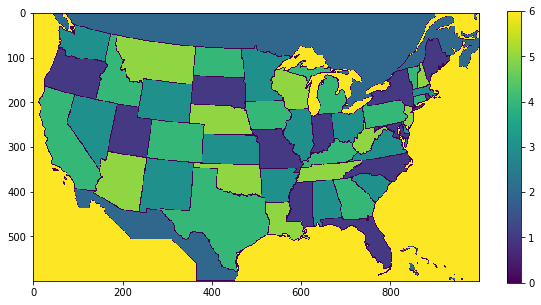

In [10]:
#this may take a moment.

#create data structure containing colors 
intermediaryArray=[pinkPixel.astype(int),
                  orangePixel.astype(int),
                  redPixel.astype(int),
                  greenPixel.astype(int),
                  yellowPixel.astype(int),
                  politicalWater.astype(int)]

#create a blank parcellation array
selectionArray=np.zeros([standardResize[0],standardResize[1]], dtype=int)
                   
#precompute a parcellation
#iterate over the colors in the intermediaryArray
for iColors in range(len(intermediaryArray)):
    #set the current color
    currentColor=intermediaryArray[iColors]
    #create a temporary array to hold the distances for this color
    currentColorArray=np.zeros([standardResize[0],standardResize[1]])
    
    #iterate over the pixels
    for iRows in range(standardResize[0]):
        for iColumns in range(standardResize[1]):
            
            #extract the current pixel
            curPixelVal=politicalResizedData[iRows,iColumns]
        
            #compute the distance for this pixel
            currentColorArray[iRows,iColumns]=multiDHypot(curPixelVal,intermediaryArray[iColors])
            
    #for those pixels that are within 1 color distance of the current color, place the current index plus 1        
    selectionArray[currentColorArray<1]=iColors+1

#plot what we just did    
selectionHeatMap=imshow(selectionArray)
selectionMap= plt.gcf()
selectionMap.colorbar(selectionHeatMap)
selectionMap.set_size_inches(10, 5)    

The code above looks quite similar to previous instances where we have computed the distances, but this time we did something different.  Instead of doing this for one pixel color, we looped across the list of RGB color values in "intermediaryArray" with:

for iColors in range(len(intermediaryArray)):

and, having done this, we created a "paint by numbers" representation of the political map where each pixel that was equal to our current color had a value (corresponding to the current entry in the array) placed in it.  We did this with this line:

selectionArray[currentColorArray<1]=iColors+1

Now that we have this "paint by numbers" representation, lets look at unique "masks" that we can generate using this data.  In this case, yellow will indicate pixels matching the current color if interest, while blue will indicate pixels that *do not* match the current color of interest.

In [11]:
from ipywidgets import Dropdown

#function for plotting the extracted color/number
def extractPolitical(selectionArray,stateColor):
    selectionOutput=np.zeros([standardResize[0],standardResize[1]])
    selectionOutput=selectionArray==stateColor
    
    imshow(selectionOutput)
    selectionMap= plt.gcf()
    selectionMap.set_size_inches(10, 10)

#wrapper for function
def updatePolPlot(stateColor):
    extractPolitical(selectionArray,stateColor)

#create dropdown widget
#stateColor=Dropdown(options=[('pink',pinkPixel), ('orange',orangePixel), ('red',redPixel),('green',greenPixel),('yellow',yellowPixel)],
stateColor=Dropdown(options=[('orange',2) ,('pink',1) , ('red',3),('green',4),('yellow',5),('blue',6)],
                    value=2,
                    description='colorSelect:')

#establish interactivity
interact(updatePolPlot, stateColor=stateColor) 

interactive(children=(Dropdown(description='colorSelect:', options=(('orange', 2), ('pink', 1), ('red', 3), ('…

<function __main__.updatePolPlot(stateColor)>

Lets think back to the masks for the geographic and political maps we made earlier and the way we aligned them.  Now that we have **both** a rough data alignment, **and** a method for indexing to specific subsets of pixels, can we extract the actual satellite geographic data (RGB values) using the "paint by numbers" representation, thereby pulling out certian sub-sections?

In [12]:
#first lets use np.roll to align the images.
#It isn't the most elegant way to align the images for various reasons, but straightforward enough for our purposes
#apply the shift to the map
xAlign=xOffset.value
print(xAlign)
yAlign=yOffset.value
print(yAlign)

#apply the y shift
extractPoliticalYShifted=np.roll(selectionArray,yAlign,0)
#apply the x shift
extractPoliticalXYShifted=np.roll(extractPoliticalYShifted,xAlign,1)

#plot the current subsections
def extractPolitical(geoResizeData,extractPoliticalXYShifted,stateColor):
    selectionOutput=np.copy(geoResizeData)
    selectionOutput[extractPoliticalXYShifted!=stateColor]=[0,0,0]
    
    imshow(selectionOutput)
    selectionMap= plt.gcf()
    selectionMap.set_size_inches(10, 10)

#wrapper
def updatePolPlot(stateColor):
    extractPolitical(geoResizeData,extractPoliticalXYShifted,stateColor)

#create dropdown widget
#stateColor=Dropdown(options=[('pink',pinkPixel), ('orange',orangePixel), ('red',redPixel),('green',greenPixel),('yellow',yellowPixel)],
stateColor=Dropdown(options=[('orange',2) ,('pink',1) , ('red',3),('green',4),('yellow',5),('blue',6)],
                    value=2,
                    description='colorSelect:')

#establish interactivity
interact(updatePolPlot, stateColor=stateColor) 

0
0


interactive(children=(Dropdown(description='colorSelect:', options=(('orange', 2), ('pink', 1), ('red', 3), ('…

<function __main__.updatePolPlot(stateColor)>

### Closing Remarks

Admittedly, it's not a perfect alignment that we did, so the areas we are extracting aren't exactly on spot, but nonetheless you should have general idea of how we can use an aligmnent of two maps to leverage information from one to extract information from another.  For example, we could compute the average color of the terrain in the sub-section we've chosen.  Alternatively, if we used a population density map instead, we could roughly compute the number of people living in the pink, red, green, etc. states.

Lets solidify a couple intuitons about what we did here:

First, we should remember that the satellite imagery was our **raw data** of sorts.  In this case, the **raw data** was simply 3 channels of RGB reflectance values (i.e. a "picture").  However, as alluded to above, it could have been population densities, demographic information, or any number of other data domains.  What matters is that the **raw data** is the data we wish to select sub-sections from (using the **parcellation**).

Second, we should remember that the political mapping was a discrete mapping with (in essence) each pixel assigned to one of some limited number of categories.  In the political mapping the particular color assigned to a given state was arbitrary, but we could imagine it such that each state was colored with a *distinct* color such that there were 48 (it was a continental US map, after all) unique colors.  With this we could have indexed into the raw data for any *particular* state.  This act of dividing up a larger body into some number of discrete sections is a process that is referred to as **parcellation**.  In this way, data objects that contain this sort of information are **parcellation maps**, in that they establish a systematic and explicit correspondence (i.e. mapping) between **parcels** (i.e. specified sub-sections) of the larger whole, and some finite list of discrete entites (i.e. an ontology).  Furthermore, **parcellation maps** manifest this mapping relation because they "represent" the larger body in an analogue fashion, meaning that the structural (i.e. spatial) relations of the atomistic sub-components of the source entity are recapitualited by the corresponding elements of the **parcellation map**.  Basically, this just a formal way of describing what it is about **parcellations** that allows us to directly overlay them onto our raw data and then make use of them in the ways we have demonstrated and discussed.

Third, it is also important to remember that the usefulness of these parcellations is *highly* dependent on how well aligned they are to the entity they represent.  The less well aligned the parcellation is with its source entity, the less the correspondence relation between the parcellation and the source entity is preserved, and the less useful the parcellation can be.  In the case of geographic maps, a misalignment can result in innaccurate data extraction, but for some **raw data** and **parcellation** types, a mismatch can be like an indexing error in a data array. Indeed, this is the case with some ways of representing white matter parcellations, which we will discuss in more detail later.  

Fourth, and finally, on the topic of **parcellations** and the list of sub-divisions they divide the larger body into, its also worth noting that a parcellation is only useful to the degree that we understand what the parcells correspoond to.  We didn't really need a guide to tell that the color divisions of the political map corresponded to various (arbitrary) collections of states, nor would we likely need something to tell us which state was which if each had a different color--in either case this is probaby because we are familiar with the borders of the states.  However, if our parcellation corresponded to a categorical or conceptual framework that we weren't familiar with, we would need some index, dictionary, or guide to tell us what each unique value of the "paint by numbers" mapping corresponded to and/or how the mapping was established.  Without such a guide it would be difficult to discern a particular parcellation from a randomized parcellation.

In the next section we will begin bridging into neuroimaging data.  We'll start this process by briefly setting up some intuitions about the similarities and differences between JPEG images and brain images, before moving on to a more explicit exploration of the particular data object features of brain images. 